In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# you should run this notebook in the root directory of the project for the following imports to work
# %cd ..
%cd /private/home/pfz/00-watermark/hidden
from videoseal.wm.watermarker import Hidden256, DctDwt

/private/home/pfz/00-watermark/hidden


/private/home/pfz/anaconda3/envs/stablesign/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load and build models 

In [2]:
"""
This network has been trained in 2 steps
1. train the encoder and decoder without perceptual attenuation, at resolution 256
2. train the encoder with perceptual attenuation and downscaling, at resolution 512 -> downscaled to 256

The corresponding command lines are:
1. torchrun --nproc_per_node=2 main.py --local_rank 0 --batch_size 16 --p_color_jitter 0.0 --p_blur 1.0 --p_rot 1.0 --p_crop 1.0 --p_res 1.0 --p_jpeg 1.0 --scaling_w 0.3 --scale_channels False --attenuation none --loss_margin 1 --loss_w_type bce --scheduler CosineLRScheduler,lr_min=1e-6,t_initial=600,warmup_lr_init=1e-6,warmup_t=10 --optimizer Lamb,lr=2e-3 --epochs 600 --img_size 256 --num_bits 48 --eval_freq 5 --val_dir /datasets01/COCO/060817/test2014/ --train_dir /datasets01/COCO/060817/train2014/ --output_dir /checkpoint/pfz/2023_logs/0828_hidden_multiscale_new/_scaling_w=0.3_optimizer=Lamb,lr=2e-3
2. torchrun --nproc_per_node=2 main.py --local_rank 0 --batch_size 16 --batch_size_eval 32 --p_color_jitter 0.0 --p_blur 1.0 --p_rot 1.0 --p_crop 1.0 --p_res 1.0 --p_jpeg 1.0 --scaling_w 1.0 --scale_channels False --attenuation jnd --downsampling_res 128 --loss_margin 1 --loss_w_type bce --scheduler CosineLRScheduler,lr_min=1e-6,t_initial=100,warmup_lr_init=1e-6,warmup_t=5 --optimizer Lamb,lr=1e-3 --discriminator none --epochs 100 --img_size 512 --num_bits 48 --eval_freq 5 --resume_from /checkpoint/pfz/2023_logs/0828_hidden_multiscale_new/_scaling_w=0.3_optimizer=Lamb,lr=2e-3/checkpoint.pth --val_dir /datasets01/COCO/060817/test2014/ --train_dir /datasets01/COCO/060817/train2014/ --output_dir /checkpoint/pfz/2023_logs/0904_hidden_best_ctd_512_downsample_bis/_downsampling_res=128 
"""
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(f"running on device: {device}")

nbits = 48

ckpt_path = "/private/home/pfz/00-watermark/hidden/models/0904_train256_ft512to256.pth"
watermarker_hidden = Hidden256(ckpt_path, scaling_w=1.0, device=device)
watermarker_dctdwt = DctDwt(nbits=nbits)

running on device: cpu
loading weights from /private/home/pfz/00-watermark/hidden/models/0904_train256_ft512to256.pth
<All keys matched successfully>
<All keys matched successfully>


### Create encoder with downsampling and attenuation of watermark

Image size: (962, 1202)

>>> Neural based method (revisited hidden)


watermark insertion time: 0.179s
PSNR: 42.608
SSIM: 0.972
Bit accuracy: 1.000

>>> DCT-DWT based method
watermark insertion time: 0.162s
PSNR: 42.044
SSIM: 0.969
Bit accuracy: 1.000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


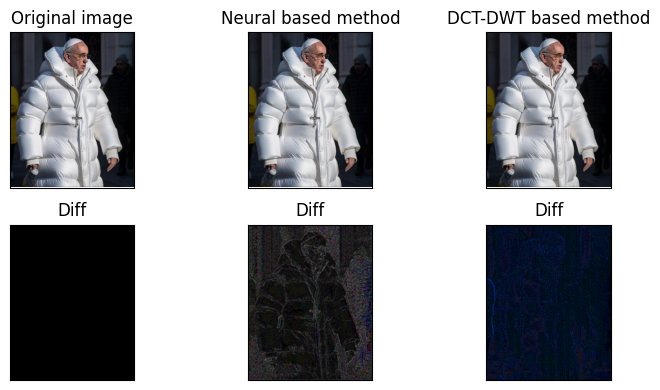


Images saved in imgs/wm


In [3]:
FIGSIZE = 2 # figure size, lower for github, you can increase to plot in higher resolution

# load image
img_path = "imgs/01.png"
img = Image.open(img_path).convert('RGB')
print(f"Image size: {img.size}")

# create message
msg = np.array([0,0,0,1,1,0,1,0,1,1,0,1,1,0,0,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,1,1,0,1,0,0,0,1,1,1,0,0,0,0])

print(f"\n>>> Neural based method (revisited hidden)")
# start timer
time0 = time.time()
# encode
img_w = watermarker_hidden.encode(img, msg)
# end timer
time1 = time.time()
print(f"watermark insertion time: {time1 - time0:.3f}s")
# metrics
psnr = peak_signal_noise_ratio(np.array(img), np.array(img_w))
ssim = structural_similarity(np.array(img), np.array(img_w), multichannel=True, channel_axis=2)
bit_acc = np.mean(msg == watermarker_hidden.decode(img_w))
print(f"PSNR: {psnr:.3f}")
print(f"SSIM: {ssim:.3f}")
print(f"Bit accuracy: {bit_acc:.3f}")

print(f"\n>>> DCT-DWT based method")
# start timer
time0 = time.time()
# encode
img_w_dctdwt = watermarker_dctdwt.encode(img, msg)
# end timer
time1 = time.time()
print(f"watermark insertion time: {time1 - time0:.3f}s")
# metrics
psnr = peak_signal_noise_ratio(np.array(img), np.array(img_w_dctdwt))
ssim = structural_similarity(np.array(img), np.array(img_w_dctdwt), multichannel=True, channel_axis=2)
bit_acc = np.mean(msg == watermarker_dctdwt.decode(img_w_dctdwt))
print(f"PSNR: {psnr:.3f}")
print(f"SSIM: {ssim:.3f}")
print(f"Bit accuracy: {bit_acc:.3f}")

# plot images and diffs
fig, axs = plt.subplots(2, 3, figsize=(FIGSIZE * 4, FIGSIZE * 2))
axs[0,0].imshow(img)
axs[0,0].set_title("Original image")
axs[0,1].imshow(img_w)
axs[0,1].set_title("Neural based method")
axs[0,2].imshow(img_w_dctdwt)
axs[0,2].set_title("DCT-DWT based method")
diff = np.abs(np.asarray(img).astype(int) - np.asarray(img).astype(int)) * 20
axs[1,0].imshow(diff)
axs[1,0].set_title("Diff")
diff = np.abs(np.asarray(img_w).astype(int) - np.asarray(img).astype(int)) * 20
axs[1,1].imshow(diff)
axs[1,1].set_title("Diff")
diff = np.abs(np.asarray(img_w_dctdwt).astype(int) - np.asarray(img).astype(int)) * 30
axs[1,2].imshow(diff)
axs[1,2].set_title("Diff")
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

# save images
save_dir = "imgs/wm"
os.makedirs(save_dir, exist_ok=True)
img_w.save(os.path.join(save_dir, "hidden.png"))
img_w_dctdwt.save(os.path.join(save_dir, "dctdwt.png"))
print(f"\nImages saved in {save_dir}")

### Robustness analysis

We show the bit accuracy, which is the number of bits correctly decoded over the total number of bits, for different augmentations.


>>> Neural based method (revisited hidden)
Average decoding time: 0.070s


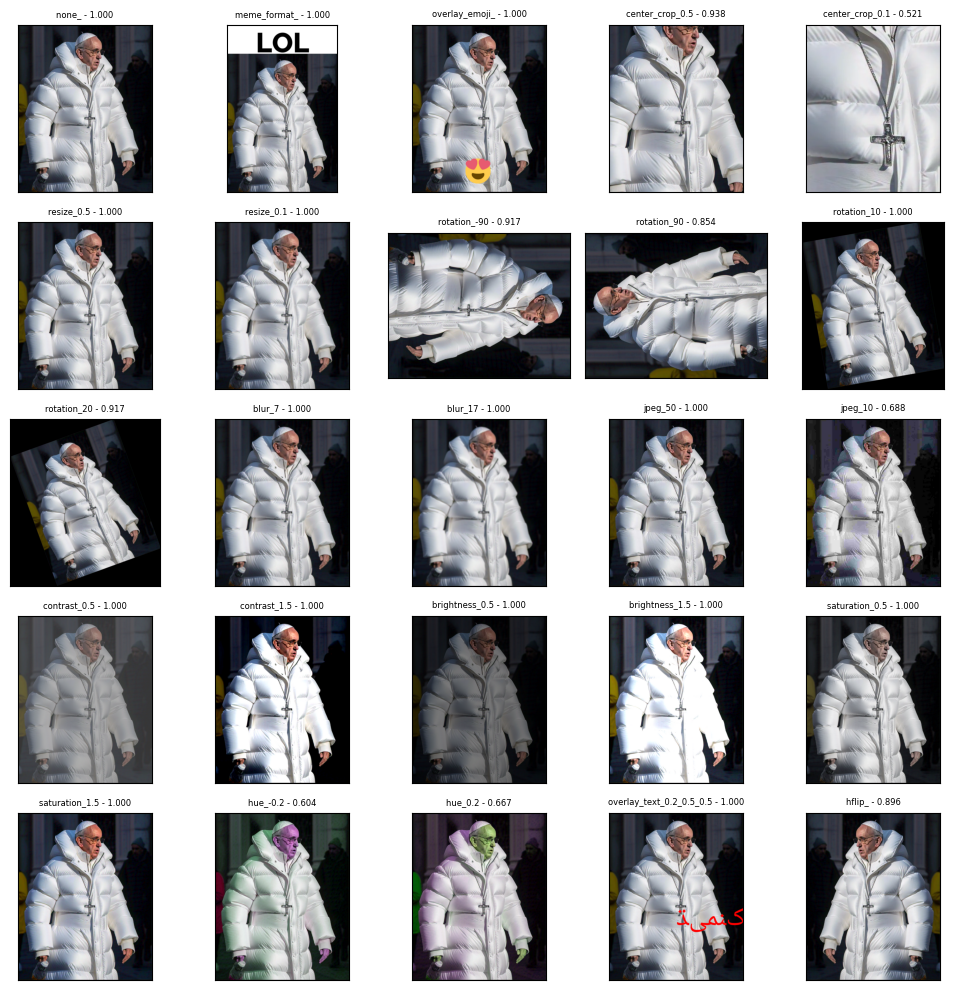


>>> DCT-DWT based method
Average decoding time: 0.104s


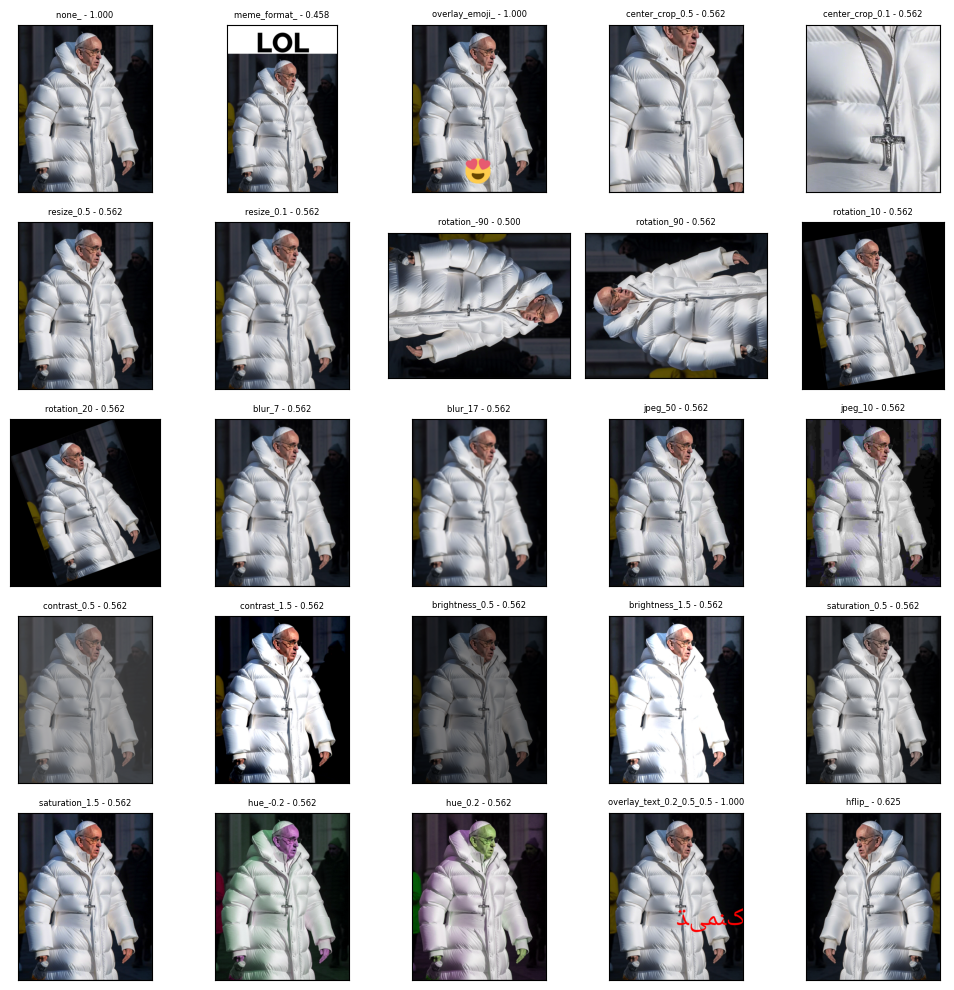

In [4]:
from videoseal.wm.utils_img import generate_attacks

attacks = [{'attack': 'none'}] \
    + [{'attack': 'meme_format'}] \
    + [{'attack': 'overlay_emoji'}] \
    + [{'attack': 'center_crop', 'scale': 0.5}, {'attack': 'center_crop', 'scale': 0.1}] \
    + [{'attack': 'resize', 'scale': 0.5}, {'attack': 'resize', 'scale': 0.1}] \
    + [{'attack': 'rotation', 'angle': -90}, {'attack': 'rotation', 'angle': 90}, {'attack': 'rotation', 'angle': 10}, {'attack': 'rotation', 'angle': 20}] \
    + [{'attack': 'blur', 'kernel_size': 7}, {'attack': 'blur', 'kernel_size': 17}] \
    + [{'attack': 'jpeg', 'quality': 50}, {'attack': 'jpeg', 'quality': 10}] \
    + [{'attack': 'contrast', 'contrast_factor': 0.5}, {'attack': 'contrast', 'contrast_factor': 1.5}] \
    + [{'attack': 'brightness', 'brightness_factor': 0.5}, {'attack': 'brightness', 'brightness_factor': 1.5}] \
    + [{'attack': 'saturation', 'saturation_factor': 0.5}, {'attack': 'saturation', 'saturation_factor': 1.5}] \
    + [{'attack': 'hue', 'hue_factor': -0.2}, {'attack': 'hue', 'hue_factor': 0.2}] \
    + [{'attack': 'overlay_text', 'font_size': 0.2, 'x_pos': 0.5, 'y_pos': 0.5}] \
    + [{'attack': 'hflip'}] \


augm_dir = "imgs/augm"
os.makedirs(augm_dir, exist_ok=True)

for ii, watermarker in enumerate([watermarker_hidden, watermarker_dctdwt]):

    if ii == 0:
        attacked_imgs = generate_attacks(img_w , attacks)
        print(f"\n>>> Neural based method (revisited hidden)")
    else:
        attacked_imgs = generate_attacks(img_w_dctdwt , attacks)
        print(f"\n>>> DCT-DWT based method")

    save_dicts = []
    times = []
    for jj, attacked_img in enumerate(attacked_imgs):
        attack = attacks[jj].copy()

        # create attack name
        attack_name = attack.pop('attack')
        param_names = ['param%i'%kk for kk in range(len(attack.keys()))]
        attack_params = dict(zip(param_names,list(attack.values())))
        attack_name = attack_name + '_' + '_'.join([f"{v}" for k,v in attack_params.items()])

        # decode
        time_0 = time.time()
        decoded = watermarker.decode(attacked_img) # b c h w -> b k
        times.append(time.time() - time_0)

        # compute metrics
        diff = (~np.logical_xor(decoded, msg)) # b k -> b k
        hamming = diff.shape[-1] - np.sum(diff) # b
        bit_accs = np.sum(diff) / diff.shape[-1] # b k -> b
        word_accs = (bit_accs == 1) # b
        save_dicts.append({
            "attack": attack_name,
            'hamming': hamming,
            'bit_acc': bit_accs,
            'word_acc': 1.0 if word_accs else 0.0,
            'aug_img': attacked_img,
        })

        # save augmented image
        if ii == 0:
            attacked_img.save(os.path.join(augm_dir, f"{attack_name}.png"))

    print(f"Average decoding time: {np.mean(times):.3f}s")

    figsize = (FIGSIZE*5, FIGSIZE*5)
    fig, axs = plt.subplots(5, 5, figsize=figsize) # 1 row, 4 columns
    for i in range(5):
        for j in range(5):
            axs[i, j].grid('off')
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            axs[i, j].set_title(f"{save_dicts[i*5+j]['attack']} - {save_dicts[i*5+j]['bit_acc']:.3f}", fontsize=6)
            axs[i, j].imshow(save_dicts[i*5+j]['aug_img'])
    plt.tight_layout()
    plt.show()